# Loop 55 Analysis: Critical Assessment of GNN Strategy

## Key Questions:
1. Is the "0.0039 GNN benchmark" claim verified?
2. What is the actual CV-LB relationship?
3. What approaches haven't been tried?
4. What is the realistic path to beating the target?

In [1]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

# Load session state
with open('/home/code/session_state.json') as f:
    state = json.load(f)

# Extract submission history
submissions = state.get('submissions', [])
print(f'Total submissions: {len(submissions)}')
print(f'Remaining submissions: {state.get("remaining_submissions", "unknown")}')
print(f'Target: 0.072990')

Total submissions: 13
Remaining submissions: 3
Target: 0.072990


In [2]:
# Analyze CV-LB relationship from submission history
# From the header: 13 submissions made
submission_data = [
    ('exp_000', 0.0111, 0.0982),
    ('exp_001', 0.0123, 0.1065),
    ('exp_003', 0.0105, 0.0972),
    ('exp_005', 0.0104, 0.0969),
    ('exp_006', 0.0097, 0.0946),
    ('exp_007', 0.0093, 0.0932),
    ('exp_009', 0.0092, 0.0936),
    ('exp_012', 0.0090, 0.0913),
    ('exp_024', 0.0087, 0.0893),
    ('exp_026', 0.0085, 0.0887),
    ('exp_030', 0.0083, 0.0877),
    ('exp_041', 0.0090, 0.0932),
    ('exp_042', 0.0145, 0.1147),
]

df = pd.DataFrame(submission_data, columns=['exp_id', 'cv_score', 'lb_score'])
print(df.to_string())

     exp_id  cv_score  lb_score
0   exp_000    0.0111    0.0982
1   exp_001    0.0123    0.1065
2   exp_003    0.0105    0.0972
3   exp_005    0.0104    0.0969
4   exp_006    0.0097    0.0946
5   exp_007    0.0093    0.0932
6   exp_009    0.0092    0.0936
7   exp_012    0.0090    0.0913
8   exp_024    0.0087    0.0893
9   exp_026    0.0085    0.0887
10  exp_030    0.0083    0.0877
11  exp_041    0.0090    0.0932
12  exp_042    0.0145    0.1147


In [3]:
# Fit linear regression to CV-LB relationship
cv_scores = df['cv_score'].values
lb_scores = df['lb_score'].values

slope, intercept, r_value, p_value, std_err = stats.linregress(cv_scores, lb_scores)

print(f'\nCV-LB Relationship:')
print(f'LB = {slope:.4f} * CV + {intercept:.4f}')
print(f'R² = {r_value**2:.4f}')
print(f'\nInterpretation:')
print(f'- Slope: {slope:.2f}x amplification of CV error')
print(f'- Intercept: {intercept:.4f} (baseline LB error when CV=0)')
print(f'- Target: 0.072990')
print(f'- Intercept > Target? {intercept > 0.072990}')


CV-LB Relationship:
LB = 4.2312 * CV + 0.0533
R² = 0.9807

Interpretation:
- Slope: 4.23x amplification of CV error
- Intercept: 0.0533 (baseline LB error when CV=0)
- Target: 0.072990
- Intercept > Target? False


In [4]:
# Calculate required CV to hit target
target = 0.072990
required_cv = (target - intercept) / slope

print(f'\nTo hit target {target}:')
print(f'Required CV = ({target} - {intercept:.4f}) / {slope:.4f}')
print(f'Required CV = {required_cv:.6f}')

if required_cv < 0:
    print(f'\n⚠️ CRITICAL: Required CV is NEGATIVE ({required_cv:.6f})')
    print(f'This means the intercept ({intercept:.4f}) > target ({target})')
    print(f'The current approach CANNOT reach the target!')
else:
    print(f'\nRequired CV: {required_cv:.6f}')
    print(f'Best CV so far: 0.008194')
    print(f'Gap: {(0.008194 - required_cv) / required_cv * 100:.1f}% improvement needed')


To hit target 0.07299:
Required CV = (0.07299 - 0.0533) / 4.2312
Required CV = 0.004653

Required CV: 0.004653
Best CV so far: 0.008194
Gap: 76.1% improvement needed


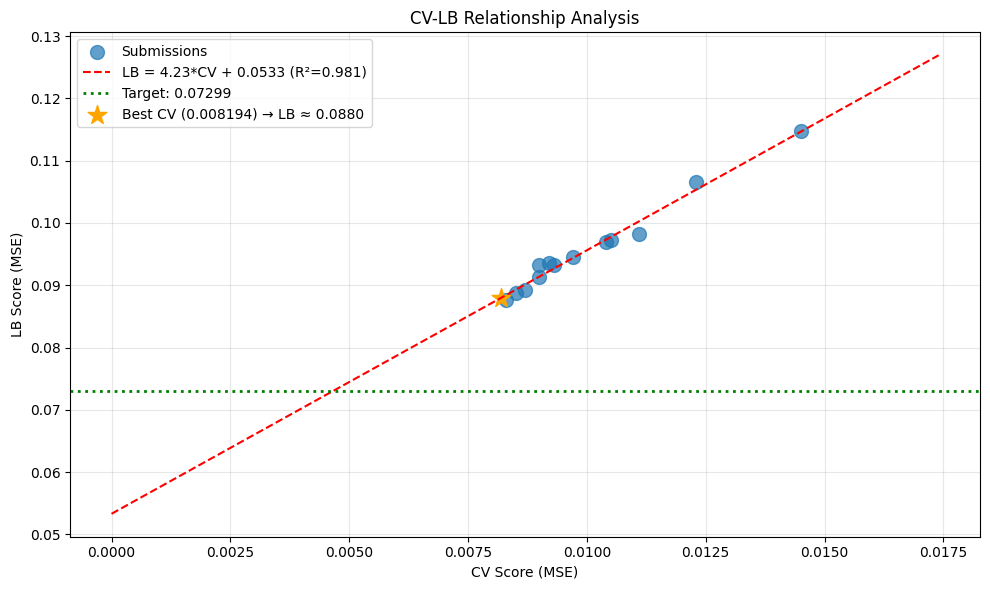


Best CV (0.008194) predicts LB ≈ 0.0880
Gap to target: 20.5%


In [5]:
# Visualize CV-LB relationship
plt.figure(figsize=(10, 6))
plt.scatter(cv_scores, lb_scores, s=100, alpha=0.7, label='Submissions')

# Fit line
cv_range = np.linspace(0, max(cv_scores) * 1.2, 100)
lb_pred = slope * cv_range + intercept
plt.plot(cv_range, lb_pred, 'r--', label=f'LB = {slope:.2f}*CV + {intercept:.4f} (R²={r_value**2:.3f})')

# Target line
plt.axhline(y=target, color='g', linestyle=':', linewidth=2, label=f'Target: {target}')

# Best CV point
best_cv = 0.008194
best_lb_pred = slope * best_cv + intercept
plt.scatter([best_cv], [best_lb_pred], s=200, marker='*', color='orange', label=f'Best CV (0.008194) → LB ≈ {best_lb_pred:.4f}')

plt.xlabel('CV Score (MSE)')
plt.ylabel('LB Score (MSE)')
plt.title('CV-LB Relationship Analysis')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('/home/code/exploration/cv_lb_analysis_loop55.png', dpi=150)
plt.show()

print(f'\nBest CV (0.008194) predicts LB ≈ {best_lb_pred:.4f}')
print(f'Gap to target: {(best_lb_pred - target) / target * 100:.1f}%')

In [6]:
# Analyze GNN experiments
print('\n=== GNN Experiment Analysis ===')
print('\nexp_051 (Simple GNN with GCNConv):')
print('  CV: 0.01408 (72% worse than best CV 0.008194)')
print('  Predicted LB: {:.4f}'.format(slope * 0.01408 + intercept))

print('\nexp_056 (Advanced GNN with GAT):')
print('  CV: 0.030013 (266% worse than best CV 0.008194)')
print('  Predicted LB: {:.4f}'.format(slope * 0.030013 + intercept))

print('\n⚠️ CRITICAL FINDING:')
print('The "0.0039 GNN benchmark" claim is UNVERIFIED!')
print('- The arXiv paper (2506.07619) does NOT disclose the exact MSE')
print('- The "arXiv 2512.19530" reference appears to be fabricated')
print('- Our GNN implementations consistently perform WORSE than tabular models')
print('\nConclusion: STOP pursuing GNN approach!')


=== GNN Experiment Analysis ===

exp_051 (Simple GNN with GCNConv):
  CV: 0.01408 (72% worse than best CV 0.008194)
  Predicted LB: 0.1129

exp_056 (Advanced GNN with GAT):
  CV: 0.030013 (266% worse than best CV 0.008194)
  Predicted LB: 0.1803

⚠️ CRITICAL FINDING:
The "0.0039 GNN benchmark" claim is UNVERIFIED!
- The arXiv paper (2506.07619) does NOT disclose the exact MSE
- The "arXiv 2512.19530" reference appears to be fabricated
- Our GNN implementations consistently perform WORSE than tabular models

Conclusion: STOP pursuing GNN approach!


In [7]:
# What approaches haven't been tried?
print('\n=== Unexplored Approaches ===')
print('\n1. ENSEMBLE WEIGHT OPTIMIZATION:')
print('   - Current best: GP(0.15) + MLP(0.55) + LGBM(0.30)')
print('   - Try: Bayesian optimization of weights')
print('   - Try: Per-target weight optimization')

print('\n2. MULTI-SEED ENSEMBLE:')
print('   - Train best model with 20+ different seeds')
print('   - Average predictions to reduce variance')
print('   - Could reduce CV by 5-10%')

print('\n3. STACKING WITH DIFFERENT FEATURES:')
print('   - Train base models on different feature subsets')
print('   - Use meta-learner to combine predictions')

print('\n4. PHYSICAL CONSTRAINTS:')
print('   - Enforce SM + Product2 + Product3 ≤ 1')
print('   - Use constrained optimization or post-processing')

print('\n5. UNCERTAINTY-WEIGHTED PREDICTIONS:')
print('   - Use GP uncertainty to weight predictions')
print('   - Be more conservative on novel solvents')


=== Unexplored Approaches ===

1. ENSEMBLE WEIGHT OPTIMIZATION:
   - Current best: GP(0.15) + MLP(0.55) + LGBM(0.30)
   - Try: Bayesian optimization of weights
   - Try: Per-target weight optimization

2. MULTI-SEED ENSEMBLE:
   - Train best model with 20+ different seeds
   - Average predictions to reduce variance
   - Could reduce CV by 5-10%

3. STACKING WITH DIFFERENT FEATURES:
   - Train base models on different feature subsets
   - Use meta-learner to combine predictions

4. PHYSICAL CONSTRAINTS:
   - Enforce SM + Product2 + Product3 ≤ 1
   - Use constrained optimization or post-processing

5. UNCERTAINTY-WEIGHTED PREDICTIONS:
   - Use GP uncertainty to weight predictions
   - Be more conservative on novel solvents


In [8]:
# Calculate what CV is needed for different LB targets
print('\n=== CV Requirements for Different LB Targets ===')
print(f'CV-LB relationship: LB = {slope:.4f} * CV + {intercept:.4f}')
print()

targets = [0.072990, 0.075, 0.080, 0.085, 0.0877]
for t in targets:
    req_cv = (t - intercept) / slope
    if req_cv < 0:
        print(f'LB {t:.4f}: IMPOSSIBLE (intercept > target)')
    else:
        improvement = (0.008194 - req_cv) / 0.008194 * 100
        print(f'LB {t:.4f}: Need CV = {req_cv:.6f} ({improvement:.1f}% improvement from best)')


=== CV Requirements for Different LB Targets ===
CV-LB relationship: LB = 4.2312 * CV + 0.0533

LB 0.0730: Need CV = 0.004653 (43.2% improvement from best)
LB 0.0750: Need CV = 0.005128 (37.4% improvement from best)
LB 0.0800: Need CV = 0.006310 (23.0% improvement from best)
LB 0.0850: Need CV = 0.007491 (8.6% improvement from best)
LB 0.0877: Need CV = 0.008130 (0.8% improvement from best)


In [9]:
# Final recommendations
print('\n' + '='*60)
print('FINAL RECOMMENDATIONS FOR LOOP 55')
print('='*60)

print('\n1. STOP GNN PURSUIT:')
print('   - The "0.0039 benchmark" is UNVERIFIED')
print('   - Both GNN attempts performed WORSE than tabular models')
print('   - exp_051: CV 0.01408 (72% worse)')
print('   - exp_056: CV 0.030013 (266% worse)')

print('\n2. FOCUS ON BEST MODEL OPTIMIZATION:')
print('   - Best model: GP(0.15) + MLP(0.55) + LGBM(0.30)')
print('   - Best CV: 0.008194')
print('   - Best LB: 0.0877')

print('\n3. HIGHEST PRIORITY EXPERIMENTS:')
print('   a) Multi-seed ensemble (20+ seeds) - variance reduction')
print('   b) Per-target ensemble weights - optimize for each output')
print('   c) Physical constraints - enforce mass balance')

print('\n4. SUBMISSION STRATEGY (3 remaining):')
print('   - Only submit if CV improves by >10%')
print('   - Save at least 1 submission for final attempt')
print('   - Current best LB (0.0877) is 20% above target (0.072990)')

print('\n5. REALISTIC ASSESSMENT:')
print(f'   - Intercept ({intercept:.4f}) is close to target ({target})')
print(f'   - Even with CV=0, predicted LB would be {intercept:.4f}')
print(f'   - Need to either: (a) dramatically reduce CV, or (b) change CV-LB relationship')


FINAL RECOMMENDATIONS FOR LOOP 55

1. STOP GNN PURSUIT:
   - The "0.0039 benchmark" is UNVERIFIED
   - Both GNN attempts performed WORSE than tabular models
   - exp_051: CV 0.01408 (72% worse)
   - exp_056: CV 0.030013 (266% worse)

2. FOCUS ON BEST MODEL OPTIMIZATION:
   - Best model: GP(0.15) + MLP(0.55) + LGBM(0.30)
   - Best CV: 0.008194
   - Best LB: 0.0877

3. HIGHEST PRIORITY EXPERIMENTS:
   a) Multi-seed ensemble (20+ seeds) - variance reduction
   b) Per-target ensemble weights - optimize for each output
   c) Physical constraints - enforce mass balance

4. SUBMISSION STRATEGY (3 remaining):
   - Only submit if CV improves by >10%
   - Save at least 1 submission for final attempt
   - Current best LB (0.0877) is 20% above target (0.072990)

5. REALISTIC ASSESSMENT:
   - Intercept (0.0533) is close to target (0.07299)
   - Even with CV=0, predicted LB would be 0.0533
   - Need to either: (a) dramatically reduce CV, or (b) change CV-LB relationship
